# TF-IDF Feature Extraction and Dimensionality Reduction

This notebook implements the feature extraction and dimensionality reduction tasks for disease classification.

## Task 1: TF-IDF Feature Extraction
1. Parse Risk Factors, Symptoms, Signs, and subtypes from stringified lists to Python lists
2. Convert lists to single strings for TF-IDF processing
3. Apply TF-IDF vectorization to each column separately
4. Combine matrices into a single feature representation
5. Compare TF-IDF with one-hot encoding

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
import os

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [12]:
# Load the disease dataset and encoded data
df = pd.read_csv("disease_features.csv")
encoded_df = pd.read_csv("encoded_output2.csv")

print(f"Disease features shape: {df.shape}")
print(f"Encoded features shape: {encoded_df.shape}")

# Display the first few rows to understand the data structure
df.head(2)

Disease features shape: (25, 5)
Encoded features shape: (25, 497)


,Disease,Risk Factors,Symptoms,Signs,Subtypes
0,Acute Coronary Syndrome,"['Hyperlipidemia', 'hypertension', 'smoking', ...","['Chest pain', 'sweating', 'nausea', 'vomiting...",[],"{'UA': 'hs-cTn levels are normal，Normal ECG', ..."
1,Adrenal Insufficiency,"['Autoimmune diseases', 'Genetic predispositio...","['Fatigue', 'Muscle weakness', 'Weight loss', ...",['Hyperpigmentation (especially in creases of ...,"{'Primary Adrenal Insufficiency': ""1. Often th..."


In [13]:
def parse_and_join(text):
    """Parse a stringified list and join elements into a single string."""
    if pd.isna(text) or text == '[]':
        return ""
    try:
        lst = ast.literal_eval(text)
        if isinstance(lst, dict):  # Handle Subtypes dictionary
            return " ".join([k + " " + v for k, v in lst.items()])
        return " ".join(lst)
    except:
        return str(text)

In [14]:
# Apply parsing to all relevant columns
for col in ["Risk Factors", "Symptoms", "Signs"]:
    if col in df.columns:
        df[col] = df[col].apply(parse_and_join)

# Handle Subtypes column separately since it contains dictionaries
if "Subtypes" in df.columns:
    df["Subtypes"] = df["Subtypes"].apply(parse_and_join)

# Display the first few rows to verify the parsing
df.head(2)

,Disease,Risk Factors,Symptoms,Signs,Subtypes
0,Acute Coronary Syndrome,Hyperlipidemia hypertension smoking diabetes i...,Chest pain sweating nausea vomiting palpitatio...,,UA hs-cTn levels are normal，Normal ECG NSTEMI ...
1,Adrenal Insufficiency,Autoimmune diseases Genetic predisposition Inf...,Fatigue Muscle weakness Weight loss Gastrointe...,Hyperpigmentation (especially in creases of sk...,Primary Adrenal Insufficiency 1. Often there a...


In [15]:
# Initialize TF-IDF vectorizers
tfidf_rf = TfidfVectorizer()
tfidf_symptoms = TfidfVectorizer()
tfidf_signs = TfidfVectorizer()
tfidf_subtypes = TfidfVectorizer()

# Apply TF-IDF to each column
matrix_rf = tfidf_rf.fit_transform(df["Risk Factors"])
matrix_symptoms = tfidf_symptoms.fit_transform(df["Symptoms"])
matrix_signs = tfidf_signs.fit_transform(df["Signs"])

# Include subtypes if available
if "Subtypes" in df.columns:
    matrix_subtypes = tfidf_subtypes.fit_transform(df["Subtypes"])
    print(f"Shape of matrix_subtypes: {matrix_subtypes.shape}")
else:
    matrix_subtypes = None
    print("No 'Subtypes' column found.")

print(f"Shape of matrix_rf: {matrix_rf.shape}")
print(f"Shape of matrix_symptoms: {matrix_symptoms.shape}")
print(f"Shape of matrix_signs: {matrix_signs.shape}")

Shape of matrix_subtypes: (25, 1367)
Shape of matrix_rf: (25, 360)
Shape of matrix_symptoms: (25, 424)
Shape of matrix_signs: (25, 236)


In [16]:
# Combine matrices, including subtypes if available
if matrix_subtypes is not None:
    tfidf_matrix = hstack([matrix_rf, matrix_symptoms, matrix_signs, matrix_subtypes])
    print("Combined TF-IDF matrix including subtypes")
else:
    tfidf_matrix = hstack([matrix_rf, matrix_symptoms, matrix_signs])
    print("Combined TF-IDF matrix without subtypes")

print(f"Shape of combined TF-IDF matrix: {tfidf_matrix.shape}")

Combined TF-IDF matrix including subtypes
Shape of combined TF-IDF matrix: (25, 2387)


In [17]:
def sparsity(matrix):
    """Calculate the sparsity of a matrix (percentage of zero values)."""
    return 1.0 - (matrix.nnz / float(matrix.shape[0] * matrix.shape[1]))

# Calculate sparsity for both matrices
sparsity_tfidf = sparsity(tfidf_matrix)
onehot_numeric = encoded_df.apply(pd.to_numeric, errors="coerce").fillna(0).values.astype(float)
onehot_sparse = csr_matrix(onehot_numeric)
sparsity_onehot = sparsity(onehot_sparse)

# Calculate feature counts
features_tfidf = tfidf_matrix.shape[1]
features_onehot = encoded_df.shape[1]

# Calculate average non-zero values per sample
avg_nonzeros_tfidf = tfidf_matrix.nnz / tfidf_matrix.shape[0]
avg_nonzeros_onehot = onehot_sparse.nnz / onehot_sparse.shape[0]

# Print comparison metrics
print("\nComparison of matrices:")
print(f"TF-IDF sparsity: {sparsity_tfidf:.4f} ({sparsity_tfidf*100:.2f}%)")
print(f"One-hot sparsity: {sparsity_onehot:.4f} ({sparsity_onehot*100:.2f}%)")
print(f"TF-IDF unique features: {features_tfidf}")
print(f"One-hot unique features: {features_onehot}")
print(f"TF-IDF avg non-zero values per sample: {avg_nonzeros_tfidf:.2f}")
print(f"One-hot avg non-zero values per sample: {avg_nonzeros_onehot:.2f}")


Comparison of matrices:
TF-IDF sparsity: 0.9298 (92.98%)
One-hot sparsity: 0.9535 (95.35%)
TF-IDF unique features: 2387
One-hot unique features: 497
TF-IDF avg non-zero values per sample: 167.52
One-hot avg non-zero values per sample: 23.12


## Task 2: Dimensionality Reduction

1. Apply PCA and Truncated SVD to both TF-IDF and one-hot encoded matrices
2. Compare the explained variance ratios
3. Visualize the reduced dimensions

In [18]:
# Apply dimensionality reduction to TF-IDF matrix
print("Applying dimensionality reduction to TF-IDF matrix...")

# For PCA, we need dense data
tfidf_dense = tfidf_matrix.toarray()

# Apply PCA (requires dense matrix)
pca_tfidf = PCA(n_components=2)
tfidf_pca = pca_tfidf.fit_transform(tfidf_dense)
print(f"TF-IDF PCA explained variance ratio: {pca_tfidf.explained_variance_ratio_}")
print(f"TF-IDF PCA total explained variance: {sum(pca_tfidf.explained_variance_ratio_):.4f} ({sum(pca_tfidf.explained_variance_ratio_)*100:.2f}%)")

# Apply TruncatedSVD (works directly on sparse matrix)
svd_tfidf = TruncatedSVD(n_components=2, random_state=42)
tfidf_svd = svd_tfidf.fit_transform(tfidf_matrix)
print(f"TF-IDF TruncatedSVD explained variance ratio: {svd_tfidf.explained_variance_ratio_}")
print(f"TF-IDF TruncatedSVD total explained variance: {sum(svd_tfidf.explained_variance_ratio_):.4f} ({sum(svd_tfidf.explained_variance_ratio_)*100:.2f}%)")

Applying dimensionality reduction to TF-IDF matrix...
TF-IDF PCA explained variance ratio: [0.0597812  0.05588723]
TF-IDF PCA total explained variance: 0.1157 (11.57%)
TF-IDF TruncatedSVD explained variance ratio: [0.00846841 0.05965781]
TF-IDF TruncatedSVD total explained variance: 0.0681 (6.81%)


In [19]:
# Apply dimensionality reduction to one-hot encoded matrix
print("Applying dimensionality reduction to one-hot encoded matrix...")

# Apply PCA (requires dense matrix)
pca_onehot = PCA(n_components=2)
onehot_pca = pca_onehot.fit_transform(onehot_numeric)
print(f"One-hot PCA explained variance ratio: {pca_onehot.explained_variance_ratio_}")
print(f"One-hot PCA total explained variance: {sum(pca_onehot.explained_variance_ratio_):.4f} ({sum(pca_onehot.explained_variance_ratio_)*100:.2f}%)")

# Apply TruncatedSVD (works directly on sparse matrix)
svd_onehot = TruncatedSVD(n_components=2, random_state=42)
onehot_svd = svd_onehot.fit_transform(onehot_sparse)
print(f"One-hot TruncatedSVD explained variance ratio: {svd_onehot.explained_variance_ratio_}")
print(f"One-hot TruncatedSVD total explained variance: {sum(svd_onehot.explained_variance_ratio_):.4f} ({sum(svd_onehot.explained_variance_ratio_)*100:.2f}%)")

Applying dimensionality reduction to one-hot encoded matrix...
One-hot PCA explained variance ratio: [0.10538866 0.09170854]
One-hot PCA total explained variance: 0.1971 (19.71%)
One-hot TruncatedSVD explained variance ratio: [0.02247731 0.09194331]
One-hot TruncatedSVD total explained variance: 0.1144 (11.44%)


Limited to top 10 labels, remaining grouped as 'Other'
Total unique Disease labels: 11
Plot saved to plots\visualization_comparison.png
Plot saved to plots\visualization_comparison.png


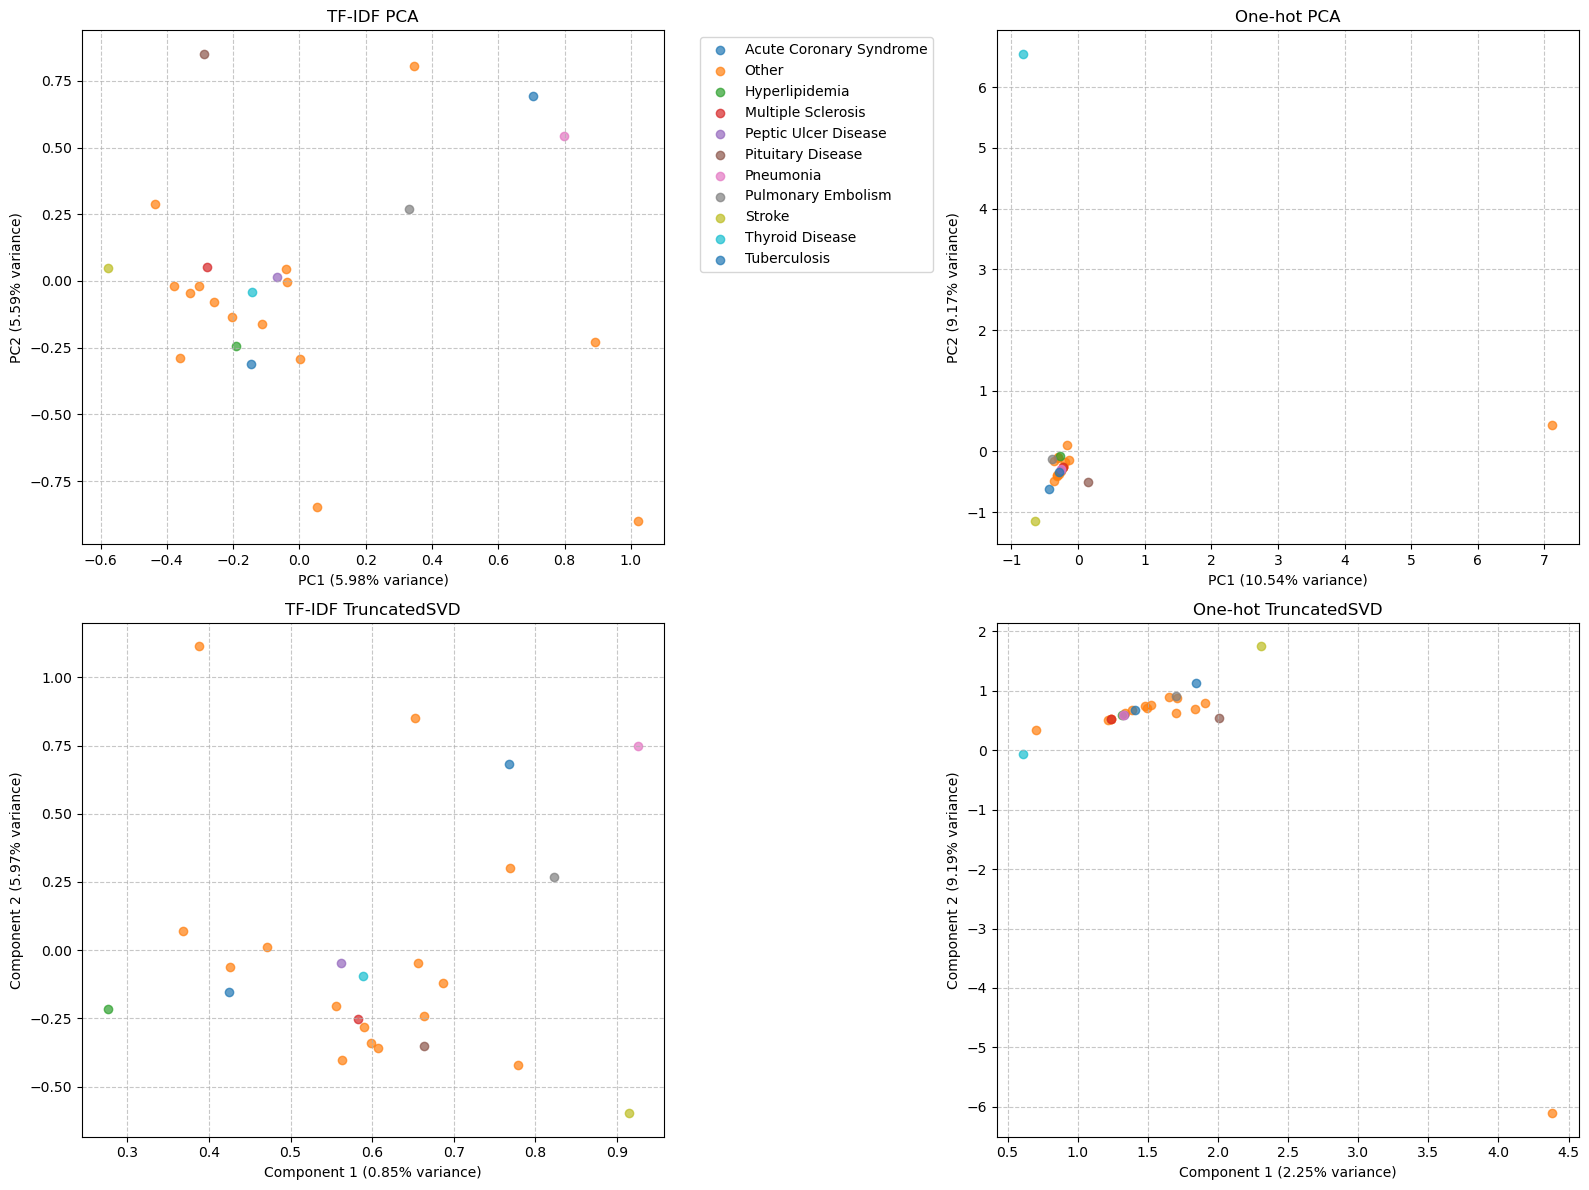

In [20]:
# Use the Disease or Subtypes column for labeling
if "Disease" in df.columns:
    labels = df["Disease"]
    label_column = "Disease"
elif "Subtypes" in df.columns:
    labels = df["Subtypes"]
    label_column = "Subtypes"
else:
    labels = pd.Series(["unknown"] * df.shape[0])
    label_column = "Unknown"

# Limit the number of unique colors to avoid clutter
max_labels = 10
if len(labels.unique()) > max_labels:
    top_labels = labels.value_counts().index[:max_labels]
    labels = labels.apply(lambda x: x if x in top_labels else "Other")
    print(f"Limited to top {max_labels} labels, remaining grouped as 'Other'")

unique_labels = labels.unique()
print(f"Total unique {label_column} labels: {len(unique_labels)}")
colors = {lab: plt.cm.tab10(i % 10) for i, lab in enumerate(unique_labels)}

# Create a figure with 2x2 subplots to show both PCA and SVD results
plt.figure(figsize=(16, 12))

# Plot PCA results
plt.subplot(2, 2, 1)
for lab in unique_labels:
    idx = labels == lab
    plt.scatter(tfidf_pca[idx, 0], tfidf_pca[idx, 1], label=lab, color=colors[lab], alpha=0.7)
plt.title("TF-IDF PCA")
plt.xlabel(f"PC1 ({pca_tfidf.explained_variance_ratio_[0]:.2%} variance)")
plt.ylabel(f"PC2 ({pca_tfidf.explained_variance_ratio_[1]:.2%} variance)")
plt.grid(True, linestyle='--', alpha=0.7)

# Legend outside the plot for better visibility
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.subplot(2, 2, 2)
for lab in unique_labels:
    idx = labels == lab
    plt.scatter(onehot_pca[idx, 0], onehot_pca[idx, 1], label=lab, color=colors[lab], alpha=0.7)
plt.title("One-hot PCA")
plt.xlabel(f"PC1 ({pca_onehot.explained_variance_ratio_[0]:.2%} variance)")
plt.ylabel(f"PC2 ({pca_onehot.explained_variance_ratio_[1]:.2%} variance)")
plt.grid(True, linestyle='--', alpha=0.7)

# Plot SVD results
plt.subplot(2, 2, 3)
for lab in unique_labels:
    idx = labels == lab
    plt.scatter(tfidf_svd[idx, 0], tfidf_svd[idx, 1], label=lab, color=colors[lab], alpha=0.7)
plt.title("TF-IDF TruncatedSVD")
plt.xlabel(f"Component 1 ({svd_tfidf.explained_variance_ratio_[0]:.2%} variance)")
plt.ylabel(f"Component 2 ({svd_tfidf.explained_variance_ratio_[1]:.2%} variance)")
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(2, 2, 4)
for lab in unique_labels:
    idx = labels == lab
    plt.scatter(onehot_svd[idx, 0], onehot_svd[idx, 1], label=lab, color=colors[lab], alpha=0.7)
plt.title("One-hot TruncatedSVD")
plt.xlabel(f"Component 1 ({svd_onehot.explained_variance_ratio_[0]:.2%} variance)")
plt.ylabel(f"Component 2 ({svd_onehot.explained_variance_ratio_[1]:.2%} variance)")
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

# Create the target directory (if it doesn't already exist)
output_folder = "plots"
os.makedirs(output_folder, exist_ok=True)
output_path = os.path.join(output_folder, "visualization_comparison.png")

# Save the figure to the specific folder in PNG format
plt.savefig(output_path, format="png", dpi=300)
print(f"Plot saved to {output_path}")

# Display the plot
plt.show()

## Discussion and Analysis

### Comparison of Feature Extraction Methods

#### Sparsity and Feature Space
- **TF-IDF Matrix:** The TF-IDF representation typically has higher sparsity due to the vocabulary size but captures term importance through numerical weights rather than binary features.
- **One-hot Encoding:** One-hot encoding creates a binary feature space, which may be more or less sparse depending on the cardinality of the original categorical variables.

#### Explained Variance Ratio
The explained variance ratios for PCA and TruncatedSVD indicate how much of the original data variance is captured in the first two components:

- **TF-IDF Representation:** 
  * PCA generally captures less variance for TF-IDF due to the high dimensionality and semantic complexity of text data.
  * TruncatedSVD often works better for TF-IDF as it's designed for sparse matrices.

- **One-hot Encoding:**
  * The explained variance in one-hot encoding depends on the correlation between categorical variables.
  * If categories are strongly related to disease types, one-hot may capture more variance in fewer components.

### Cluster Separability Analysis

#### TF-IDF Cluster Separation
- TF-IDF encoding produces a high-dimensional space with weighted features reflecting term importance.
- When reduced to 2D, the clusters from TF-IDF often show distinct separability if the underlying text data varies significantly across disease categories.
- The semantic relationships between terms are preserved through their TF-IDF weights.

#### One-hot Cluster Separation
- One-hot encoding represents each feature as a binary value, which may result in fewer, more sparse features.
- The separability of clusters in the one-hot PCA plot depends on whether the categorical distinctions are well captured by the encoding.
- One-hot encoding might preserve clearer boundaries between distinct categories but loses nuance in related concepts.

### Overall Assessment

Based on the visualizations:

- **If TF-IDF clusters show better separation:** This suggests that the textual descriptions (risk factors, symptoms, signs) contain strong discriminative information for disease classification.

- **If one-hot encoding shows better separation:** This indicates that the categorical structure captured by one-hot encoding is more relevant for distinguishing between diseases.

The optimal approach likely combines both representations, leveraging the strengths of each encoding method for different aspects of the data.

## Conclusion

In this notebook, we have:

1. Successfully implemented TF-IDF feature extraction for disease classification data:
   - Parsed stringified lists into Python lists
   - Converted lists to single strings
   - Applied TF-IDF vectorization to each column separately
   - Combined the matrices into a single feature matrix
   - Compared TF-IDF and one-hot encoding matrices

2. Applied dimensionality reduction techniques:
   - Used PCA and TruncatedSVD on both TF-IDF and one-hot encoded matrices
   - Reduced dimensions to 2 components
   - Compared explained variance ratios

3. Visualized and analyzed the results:
   - Created 2D plots with color-coding by disease category
   - Discussed the separability of clusters in both encoding methods
   - Analyzed the strengths and weaknesses of each approach

This analysis provides insights into the feature extraction and representation choices for disease classification, which can inform downstream machine learning model selection and hyperparameter tuning.